In [1]:
import numpy as np
import os
import time
%matplotlib inline
import matplotlib.pyplot as mp
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as om
import torchvision as tv
import torch.utils.data as dat

# confusion matrix plotting
from sklearn.metrics import confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix

if torch.cuda.is_available():     # Make sure GPU is available
    dev = torch.device("cuda:0")
    kwar = {'num_workers': 8, 'pin_memory': True}
    cpu = torch.device("cpu")
else:
    print("Warning: CUDA not found, CPU only.")
    dev = torch.device("cpu")
    kwar = {}
    cpu = torch.device("cpu")

np.random.seed(551)

In [3]:
dataDir = 'data/resized'               # The main data directory
classNames = os.listdir(dataDir)  # Each type of image can be found in its own subdirectory
numClass = len(classNames)        # Number of types = number of subdirectories
imageFiles = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                     # A nested list of filenames
numEach = [len(imageFiles[i]) for i in range(numClass)]     # A count of each type of image
imageFilesList = []               # Created an un-nested list of filenames
imageClass = []                   # The labels -- the type of each individual image in the list
for i in range(numClass):
    imageFilesList.extend(imageFiles[i])
    imageClass.extend([i]*numEach[i])
numTotal = len(imageClass)        # Total number of images
imageWidth, imageHeight = Image.open(imageFilesList[0]).size         # The dimensions of each image

print("There are",numTotal,"images in",numClass,"distinct categories")
print("Label names:",classNames)
print("Label counts:",numEach)
print("Image dimensions:",imageWidth,"x",imageHeight)

There are 58954 images in 6 distinct categories
Label names: ['CXR', 'ChestCT', 'Hand', 'BreastMRI', 'HeadCT', 'AbdomenCT']
Label counts: [10000, 10000, 10000, 8954, 10000, 10000]
Image dimensions: 64 x 64


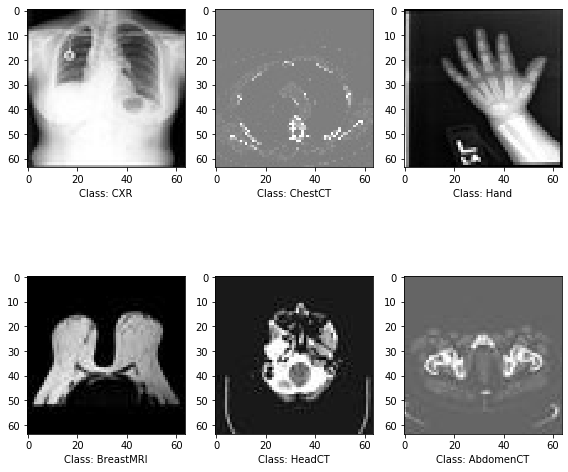

In [4]:
mp.subplots(3,2,figsize=(8,8))
for i in range(numClass): 
    im = Image.open(imageFiles[i][np.random.randint(numEach[i])])   # Randomly sample one image per class
    arr = np.array(im)
    mp.subplot(2,3,i+1)
    mp.xlabel('Class: '+classNames[i])
    mp.imshow(arr,cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()

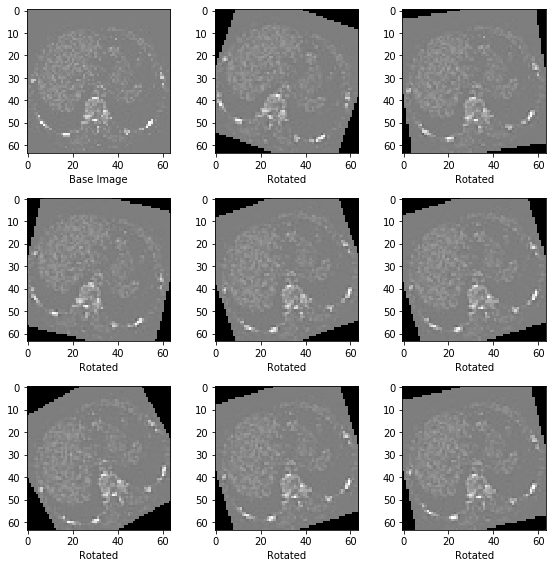

In [5]:
maxRot = 30
randRot = tv.transforms.RandomRotation(maxRot,resample=Image.BICUBIC)
baseImage = Image.open(imageFiles[np.random.randint(6)][np.random.randint(8000)])
mp.subplots(3,3,figsize=(8,8))
mp.subplot(3,3,1)
mp.xlabel('Base Image')
mp.imshow(np.array(baseImage),cmap='gray',vmin=0,vmax=255)
for i in range(8):
    randImage = randRot(baseImage)
    mp.subplot(3,3,i+2)
    mp.xlabel('Rotated')
    mp.imshow(np.array(randImage),cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()

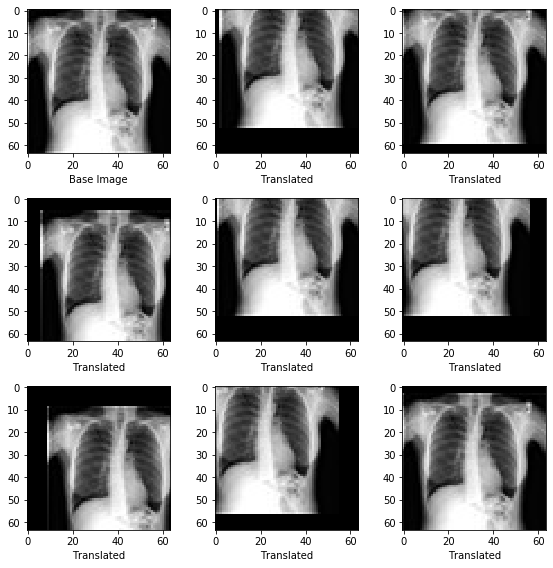

In [6]:
maxTrX = 0.2
maxTrY = 0.2
randTr = tv.transforms.RandomAffine(0,translate=(maxTrX,maxTrY),resample=Image.BICUBIC)
baseImage = Image.open(imageFiles[np.random.randint(6)][np.random.randint(8000)])
mp.subplots(3,3,figsize=(8,8))
mp.subplot(3,3,1)
mp.xlabel('Base Image')
mp.imshow(np.array(baseImage),cmap='gray',vmin=0,vmax=255)
for i in range(8):
    randImage = randTr(baseImage)
    arr = np.array(im)
    mp.subplot(3,3,i+2)
    mp.xlabel('Translated')
    mp.imshow(np.array(randImage),cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()

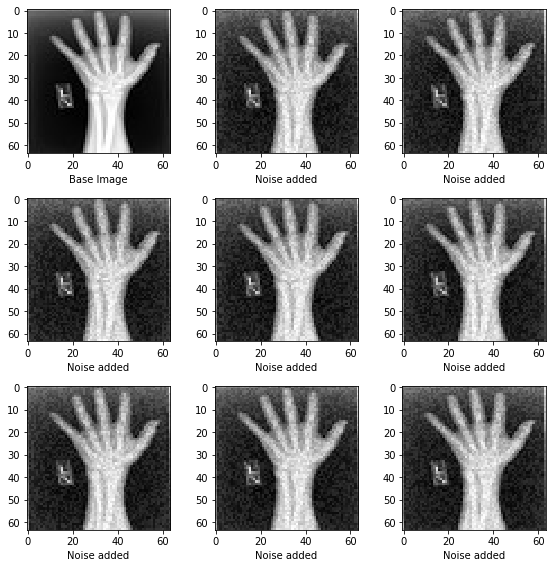

In [7]:
noiseStrength = 0.15
baseImage = Image.open(imageFiles[np.random.randint(6)][np.random.randint(8000)])
mp.subplots(3,3,figsize=(8,8))
mp.subplot(3,3,1)
mp.xlabel('Base Image')
mp.imshow(np.array(baseImage),cmap='gray',vmin=0,vmax=255)
for i in range(8):
    noise = np.random.random((imageWidth,imageHeight))
    arr = np.array(baseImage)*(1-noiseStrength)+255*noiseStrength*noise
    mp.subplot(3,3,i+2)
    mp.xlabel('Noise added')
    mp.imshow(arr,cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()

In [8]:
## Run this if you want to remove augmented data
# !rm -r data/resized
# !cp -r data/resizedbackup data/resized

In [9]:
def normalizeImage(x):
    y = np.array(x)
    if(np.min(y) < np.max(y)):  # Assuming the image isn't empty, rescale so its values run from 0 to 255
        y = 255.0*(y - 1.0*np.min(y))/(1.0*np.max(y) - np.min(y))
    z = Image.fromarray(np.uint8(y))
    return z

In [10]:
numPerClass = 15000
maxRot = 30
maxTrX = 0.2
maxTrY = 0.2
noiseStrength = 0.15
randAff = tv.transforms.RandomAffine(maxRot,translate=(maxTrX,maxTrY),resample=Image.BICUBIC)

for i in range(numClass):
    print('Augmenting class',classNames[i])
    for j in range(numPerClass - numEach[i]):
        if j % 2000 == 0:
            print('Adding image number',j)
        imageID = np.random.randint(numEach[i])
        baseImage = Image.open(imageFiles[i][imageID])
        randImage = randAff(normalizeImage(baseImage))
        noise = np.random.random((imageWidth,imageHeight))
        arr = np.array(randImage)*(1-noiseStrength)+255*noiseStrength*noise
        finalImage = Image.fromarray(np.uint8(arr))
        fname = imageFiles[i][imageID][:-5]+str(j)+'a.jpeg'
        finalImage.save(fname)

Augmenting class CXR
Adding image number 0
Adding image number 2000
Adding image number 4000
Augmenting class ChestCT
Adding image number 0
Adding image number 2000
Adding image number 4000
Augmenting class Hand
Adding image number 0
Adding image number 2000
Adding image number 4000
Augmenting class BreastMRI
Adding image number 0
Adding image number 2000
Adding image number 4000
Adding image number 6000
Augmenting class HeadCT
Adding image number 0
Adding image number 2000
Adding image number 4000
Augmenting class AbdomenCT
Adding image number 0
Adding image number 2000
Adding image number 4000


In [11]:
imageFilesAug = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                       # list of all files
numEachAug = [len(imageFilesAug[i]) for i in range(numClass)]       # Count of each image class

for i in range(numClass):
    print("Category",classNames[i],"has",numEachAug[i],"images")

Category CXR has 15000 images
Category ChestCT has 15000 images
Category Hand has 15000 images
Category BreastMRI has 15000 images
Category HeadCT has 15000 images
Category AbdomenCT has 15000 images


Run the code below several times to see example outputs of augmented data.

### Code Block 7

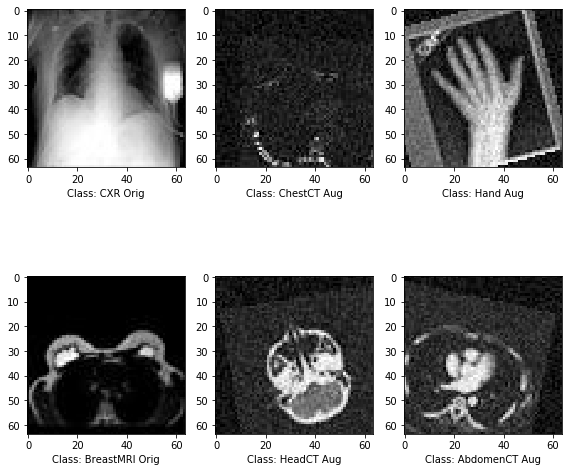

In [12]:
mp.subplots(3,2,figsize=(8,8))
for i in range(numClass):
    imageID = np.random.randint(numEachAug[i])
    im = Image.open(imageFilesAug[i][imageID])   # Randomly sample one image per class
    arr = np.array(im)
    mp.subplot(2,3,i+1)
    if imageFilesAug[i][imageID][-6] == 'a':
        imageType = ' Aug'
    else:
        imageType = ' Orig'
    mp.xlabel('Class: '+classNames[i]+imageType)
    mp.imshow(arr,cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()

In [13]:
toTensor = tv.transforms.ToTensor()
def scaleImage(x):          # Pass a PIL image, return a tensor
    y = toTensor(x)
    if(y.min() < y.max()):  # Assuming the image isn't empty, rescale so its values run from 0 to 1
        y = (y - y.min())/(y.max() - y.min()) 
    z = y - y.mean()        # Subtract the mean value of the image
    return z

In [14]:
imageFilesList = []               # Created an un-nested list of filenames
imageClass = []                   # The labels -- the type of each individual image in the list

imageFilesAug = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]
for i in range(numClass):
    imageFilesList.extend(imageFilesAug[i])
    imageClass.extend([i]*numEachAug[i])
numTotalAug = np.sum(numEachAug)

# Rescale augmented dataset and create tensors
imageTensor = torch.stack([scaleImage(Image.open(x)) for x in imageFilesList])  # Load, scale, and stack image (X) tensor
classTensor = torch.tensor(imageClass)  # Create label (Y) tensor
print("Rescaled min pixel value = {:1.3}; Max = {:1.3}; Mean = {:1.3}"
      .format(imageTensor.min().item(),imageTensor.max().item(),imageTensor.mean().item()))

Rescaled min pixel value = -0.786; Max = 0.972; Mean = -9.09e-07


In [15]:
validFrac = 0.1   # Define the fraction of images to move to validation dataset
testFrac = 0.1    # Define the fraction of images to move to test dataset
validList = []
testList = []
trainList = []
trainX = []

for i in range(numTotalAug):
    rann = np.random.random() # Randomly reassign images
    if rann < validFrac:
        validList.append(i)
    elif rann < testFrac + validFrac:
        testList.append(i)
    else:
        trainList.append(i)
        
nTrainAug = len(trainList)  # Count the number in each set
nValidAug = len(validList)
nTestAug = len(testList)
print("Training images =",nTrainAug,"Validation =",nValidAug,"Testing =",nTestAug)

trainIds = torch.tensor(trainList)    # Slice the big image and label tensors up into
validIds = torch.tensor(validList)    #       training, validation, and testing tensors
testIds = torch.tensor(testList)
trainX = imageTensor[trainIds,:,:,:]
trainY = classTensor[trainIds]
validX = imageTensor[validIds,:,:,:]
validY = classTensor[validIds]
testX = imageTensor[testIds,:,:,:]
testY = classTensor[testIds]

Training images = 71899 Validation = 9032 Testing = 9069


In [16]:
class MedNet(nn.Module):
    def __init__(self,xDim,yDim,numC):    
        super(MedNet,self).__init__() 

        
        numConvs1 = 5
        convSize1 = 7
        numConvs2 = 10
        convSize2 = 7
        numNodesToFC = numConvs2*(xDim-(convSize1-1)-(convSize2-1))*(yDim-(convSize1-1)-(convSize2-1))

       
        self.cnv1 = nn.Conv2d(1, numConvs1, convSize1)
        self.cnv2 = nn.Conv2d(numConvs1, numConvs2, convSize2)

       
        
        fcSize1 = 400
        fcSize2 = 80
        
        
        
        self.ful1 = nn.Linear(numNodesToFC,fcSize1)
        self.ful2 = nn.Linear(fcSize1, fcSize2)
        self.ful3 = nn.Linear(fcSize2,numC)
        
    def forward(self,x):
       
        
        x = F.elu(self.cnv1(x)) 
        x = F.elu(self.cnv2(x)) 
        x = x.view(-1,self.num_flat_features(x)) 
        x = F.elu(self.ful1(x)) 
        x = F.elu(self.ful2(x)) 
        x = self.ful3(x)        
        return x

    def num_flat_features(self, x):  
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

Finally, we instantiate a new model and train it on our new dataset.

In [17]:
model_aug = MedNet(imageWidth,imageHeight,numClass).to(dev)

In [18]:
learnRate = 0.01          # Define a learning rate.
maxEpochs = 20            # Maximum training epochs
t2vRatio = 1.2            # Maximum allowed ratio of validation to training loss
t2vEpochs = 3             # Number of consecutive epochs before halting if validation loss exceeds above limit
batchSize = 300           # Batch size. Going too large will cause an out-of-memory error.
trainBats = nTrainAug // batchSize       # Number of training batches per epoch. Round down to simplify last batch
validBats = nValidAug // batchSize       # Validation batches. Round down
testBats = -(-nTestAug // batchSize)     # Testing batches. Round up to include all
CEweights = torch.zeros(numClass)     # This takes into account the imbalanced dataset.
for i in trainY.tolist():             #      By making rarer images count more to the loss, 
    CEweights[i].add_(1)              #      we prevent the model from ignoring them.
CEweights = 1. / CEweights.clamp_(min=1.)                     # Weights should be inversely related to count
CEweights = (CEweights * numClass / CEweights.sum()).to(dev)  # The weights average to 1
opti = om.SGD(model_aug.parameters(), lr = learnRate)   # Initialize an optimizer


for i in range(maxEpochs):
    model_aug.train()                     # Set model to training mode
    epochLoss = 0.
    permute = torch.randperm(nTrainAug)  # Shuffle data to randomize batches
    trainX = trainX[permute,:,:,:]
    trainY = trainY[permute]
    for j in range(trainBats):        # Iterate over batches
        opti.zero_grad()              # Zero out gradient accumulated in optimizer
        batX = trainX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)   # Slice shuffled data into batches
        batY = trainY[j*batchSize:(j+1)*batchSize].to(dev)         # .to(dev) moves these batches to the GPU
        yOut = model_aug(batX)            # Evalute predictions
        loss = F.cross_entropy(yOut, batY, weight=CEweights)        # Compute loss
        epochLoss += loss.item()      # Add loss
        loss.backward()               # Backpropagate loss
        opti.step()                   # Update model weights using optimizer
    validLoss = 0.
    permute = torch.randperm(nValidAug)  # We go through the exact same steps, without backprop / optimization
    validX = validX[permute,:,:,:]    # in order to evaluate the validation loss
    validY = validY[permute]
    model_aug.eval()                      # Set model to evaluation mode
    with torch.no_grad():             # Temporarily turn off gradient descent
        for j in range(validBats):
            opti.zero_grad()
            batX = validX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
            batY = validY[j*batchSize:(j+1)*batchSize].to(dev)
            yOut = model_aug(batX)
            validLoss += F.cross_entropy(yOut, batY, weight=CEweights).item()
    epochLoss /= trainBats            # Average loss over batches and print
    validLoss /= validBats
    print("Epoch = {:-3}; Training loss = {:.4f}; Validation loss = {:.4f}".format(i,epochLoss,validLoss))
    if validLoss > t2vRatio * epochLoss:
        t2vEpochs -= 1                # Test if validation loss exceeds halting threshold
        if t2vEpochs < 1:
            print("Validation loss too high; halting to prevent overfitting")
            break

Epoch =   0; Training loss = 0.8971; Validation loss = 0.3806
Epoch =   1; Training loss = 0.2977; Validation loss = 0.2171
Epoch =   2; Training loss = 0.1648; Validation loss = 0.1443
Epoch =   3; Training loss = 0.1215; Validation loss = 0.1148
Epoch =   4; Training loss = 0.1436; Validation loss = 0.1510
Epoch =   5; Training loss = 0.1004; Validation loss = 0.0945
Epoch =   6; Training loss = 0.0780; Validation loss = 0.0788
Epoch =   7; Training loss = 0.0676; Validation loss = 0.0701
Epoch =   8; Training loss = 0.0592; Validation loss = 0.0672
Epoch =   9; Training loss = 0.0519; Validation loss = 0.0602
Epoch =  10; Training loss = 0.0459; Validation loss = 0.0537
Epoch =  11; Training loss = 0.0405; Validation loss = 0.0487
Epoch =  12; Training loss = 0.0356; Validation loss = 0.0574
Epoch =  13; Training loss = 0.0313; Validation loss = 0.0428
Validation loss too high; halting to prevent overfitting


## Validation and Comparison of Models

Let's generate a new confusion matrix and compare it to the previous model.

### Code Block 11

Augmented Accuracy =  0.9858859852243907


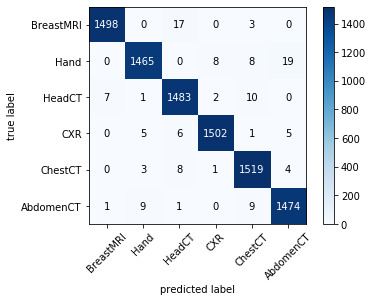

In [19]:
model_aug.eval()
with torch.no_grad():
    permute = torch.randperm(nTestAug)                     # Shuffle test data
    testX = testX[permute,:,:,:]
    testY = testY[permute]
    pred_aug = []

    for j in range(testBats):                           # Iterate over test batches
        batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
        batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
        yOut = model_aug(batX)                              # Pass test batch through model
        predict = yOut.max(1)[1].cpu().numpy()
        pred_aug = np.concatenate((pred_aug, predict))

# Augmented confusion matrix
class_names = ['BreastMRI', 'Hand', 'HeadCT', 'CXR', 'ChestCT', 'AbdomenCT']
print("Augmented Accuracy = ", accuracy_score(pred_aug, testY))
cm_aug = confusion_matrix(pred_aug, testY)
_ = plot_confusion_matrix(cm_aug, colorbar=True, class_names=class_names)